# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-hard-track-world.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on `SageMaker` and a simulation job on `RoboMaker`.

In [29]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import Markdown
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from markdown_helper import *

pd.options.display.max_rows = 5000

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [2]:
# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket) # SDK appends the job name and output folder

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-571175237970


### Define Variables

We define variables such as the job prefix for the training jobs and s3_prefix for storing metadata required for synchronization between the training and simulation jobs

In [3]:
job_name_prefix = 'rl-deepracer'

# create unique job name
tm = gmtime()
job_name = s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", tm) #Ensure S3 prefix contains SageMaker
s3_prefix_robomaker = job_name_prefix + "-robomaker-" + strftime("%y%m%d-%H%M%S", tm) #Ensure that the S3 prefix contains the keyword 'robomaker'


# Duration of job in seconds (5 hours)
job_duration_in_seconds = 3600 * 5

aws_region = sage_session.boto_region_name

if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia), US West (Oregon) and EU (Ireland). Please switch to one of these regions.")
print("Model checkpoints and other metadata will be stored at: {}{}".format(s3_output_path, job_name))

Model checkpoints and other metadata will be stored at: s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [4]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role('sagemaker')

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::571175237970:role/service-role/AmazonSageMaker-ExecutionRole-20190308T140034


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook

In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.


In [5]:
display(Markdown(generate_help_for_robomaker_trust_relationship(role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20190308T140034](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20190308T140034).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will use the default VPC configuration for this example.

In [6]:
ec2 = boto3.client('ec2')
default_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

default_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                   if group["GroupName"] == "default" and group["VpcId"] == default_vpc]

default_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                  if subnet["VpcId"] == default_vpc and subnet['DefaultForAz']==True]

print("Using default VPC:", default_vpc)
print("Using default security group:", default_security_groups)
print("Using default subnets:", default_subnets)

Using default VPC: vpc-0a358f70
Using default security group: ['sg-ca26168e']
Using default subnets: ['subnet-cd1f7591', 'subnet-3d09605a', 'subnet-f47602da', 'subnet-8255768d', 'subnet-983c05d2', 'subnet-5c893462']


A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [7]:
try:
    route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                if route_table['VpcId'] == default_vpc]
except Exception as e:
    if "UnauthorizedOperation" in str(e):
        display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
    else:
        display(Markdown(create_s3_endpoint_manually(aws_region, default_vpc)))
    raise e

print("Trying to attach S3 endpoints to the following route tables:", route_tables)

assert len(route_tables) >= 1, "No route tables were found. Please follow the VPC S3 endpoint creation "\
                              "guide by clicking the above link."

try:
    ec2.create_vpc_endpoint(DryRun=False,
                           VpcEndpointType="Gateway",
                           VpcId=default_vpc,
                           ServiceName="com.amazonaws.{}.s3".format(aws_region),
                           RouteTableIds=route_tables)
    print("S3 endpoint created successfully!")
except Exception as e:
    if "RouteAlreadyExists" in str(e):
        print("S3 endpoint already exists.")
    elif "UnauthorizedOperation" in str(e):
        display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
        raise e
    else:
        display(Markdown(create_s3_endpoint_manually(aws_region, default_vpc)))
        raise e

Trying to attach S3 endpoints to the following route tables: ['rtb-738b8a0c']
S3 endpoint already exists.


## Setup the environment


The environment is defined in a Python file called “deepracer_env.py” and the file can be found at `src/robomaker/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in this file. Action space and steering angles can be changed by modifying the step method in `DeepRacerDiscreteEnv` class.

### Configure the preset for RL algorithm
The parameters that configure the RL training job are defined in `src/robomaker/presets/deepracer.py`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [8]:
!pygmentize src/robomaker/presets/deepracer.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

from rl_coach.exploration_policies.categorical import CategoricalParameters
from rl_coach.filters.filter import NoInputFilter, NoOutputFilter, InputFilter
from rl_coach.filters.observation.observation_stacking_filter import ObservationStackingFilter
from rl_coach.filters.observation.observation_rgb_to_y_filter import ObservationRGBToYFilter
from rl_coach.filters.observation.observation_to_uint8_filter import ObservationToUInt8Filter
from rl_coach.memories.memory import Memo

### Training Entrypoint
The training code is written in the file “training_worker.py” which is uploaded in the /src directory. At a high level, it does the following:
- Uploads SageMaker node's IP address.
- Starts a Redis server which receives agent experiences sent by rollout worker[s] (RoboMaker simulator).
- Trains the model everytime after a certain number of episodes are received.
- Uploads the new model weights on S3. The rollout workers then update their model to execute the next set of episodes.

In [9]:
# Uncomment the line below to see the training code
#!pygmentize src/training_worker.py

### Train the RL model using the Python SDK Script mode¶


First, we upload the preset and envrionment file to a particular location on S3, as expected by RoboMaker.

In [10]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)

# Make sure nothing exists at this S3 prefix
!aws s3 rm --recursive {s3_location}

# Make any changes to the envrironment and preset files below and upload these files
!aws s3 cp src/robomaker/environments/ {s3_location}/environments/ --recursive --exclude ".ipynb_checkpoints*" --exclude "*.pyc"
!aws s3 cp src/robomaker/presets/ {s3_location}/presets/ --recursive --exclude ".ipynb_checkpoints*" --exclude "*.pyc"

upload: src/robomaker/environments/deepracer_env.py to s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341/environments/deepracer_env.py
upload: src/robomaker/environments/__init__.py to s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341/environments/__init__.py
upload: src/robomaker/presets/__init__.py to s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341/presets/__init__.py
upload: src/robomaker/presets/deepracer.py to s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341/presets/deepracer.py


Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [11]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [12]:
RLCOACH_PRESET = "deepracer"

instance_type = "ml.c5.2xlarge"

estimator = RLEstimator(entry_point="training_worker.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        train_max_run=job_duration_in_seconds, # Maximum runtime in seconds
                        hyperparameters={"s3_bucket": s3_bucket,
                                         "s3_prefix": s3_prefix,
                                         "aws_region": aws_region,
                                         "RLCOACH_PRESET": RLCOACH_PRESET,
                                      },
                        metric_definitions = metric_definitions,
                        subnets=default_subnets, # Required for VPC mode
                        security_group_ids=default_security_groups, # Required for VPC mode
                    )

estimator.fit(job_name=job_name, wait=False)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-571175237970
INFO:sagemaker:Creating training-job with name: rl-deepracer-sagemaker-190309-151341


### Start the Robomaker job

In [13]:
from botocore.exceptions import UnknownServiceError

robomaker = boto3.client("robomaker")

### Create Simulation Application

We first create a RoboMaker simulation application using the `DeepRacer public bundle`. Please refer to [RoboMaker Sample Application Github Repository](https://github.com/aws-robotics/aws-robomaker-sample-application-deepracer) if you want to learn more about this bundle or modify it.

In [14]:
bundle_s3_key = 'deepracer/simulation_ws.tar.gz'
bundle_source = {'s3Bucket': s3_bucket,
                 's3Key': bundle_s3_key,
                 'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE', 'version': '1.x'}

Download the public DeepRacer bundle provided by RoboMaker and upload it in our S3 bucket to create a RoboMaker Simulation Application

In [15]:
simulation_application_bundle_location = "https://s3.amazonaws.com/deepracer-managed-resources/deepracer-github-simapp.tar.gz"

!wget {simulation_application_bundle_location}
!aws s3 cp deepracer-github-simapp.tar.gz s3://{s3_bucket}/{bundle_s3_key}
!rm deepracer-github-simapp.tar.gz

--2019-03-09 15:13:57--  https://s3.amazonaws.com/deepracer-managed-resources/deepracer-github-simapp.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 988655340 (943M) [application/x-gzip]
Saving to: ‘deepracer-github-simapp.tar.gz’

deepracer-github-si 100%[===================>] 942.85M  87.4MB/s    in 10s     

2019-03-09 15:14:07 (90.2 MB/s) - ‘deepracer-github-simapp.tar.gz’ saved [988655340/988655340]

upload: ./deepracer-github-simapp.tar.gz to s3://sagemaker-us-east-1-571175237970/deepracer/simulation_ws.tar.gz


In [16]:
app_name = "deepracer-sample-application" + strftime("%y%m%d-%H%M%S", gmtime())

try:
    response = robomaker.create_simulation_application(name=app_name,
                                                   sources=[bundle_source],
                                                   simulationSoftwareSuite=simulation_software_suite,
                                                   robotSoftwareSuite=robot_software_suite,
                                                   renderingEngine=rendering_engine
                                                  )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:571175237970:simulation-application/deepracer-sample-application190309-151420/1552144460657


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [17]:
# Use more rollout workers for faster convergence
num_simulation_workers = 1

envriron_vars = {
                 "MODEL_S3_BUCKET": s3_bucket,
                 "MODEL_S3_PREFIX": s3_prefix,
                 "ROS_AWS_REGION": aws_region,
                 "WORLD_NAME": "hard_track",  # Can be one of "easy_track", "medium_track", "hard_track"
                 "MARKOV_PRESET_FILE": "%s.py" % RLCOACH_PRESET,
                 "NUMBER_OF_ROLLOUT_WORKERS": str(num_simulation_workers)}

simulation_application = {"application": simulation_app_arn,
                          "launchConfig": {"packageName": "deepracer_simulation",
                                           "launchFile": "distributed_training.launch",
                                           "environmentVariables": envriron_vars}
                         }
                            
vpcConfig = {"subnets": default_subnets,
             "securityGroups": default_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(iamRole=role,
                                            clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Continue",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig,
                                            outputLocation={"s3Bucket":s3_bucket, "s3Prefix":s3_prefix_robomaker}
                                            )
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn) 

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:571175237970:simulation-job/sim-t68w2ygxxgbv


### Visualizing the simulations in RoboMaker

You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [18]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-t68w2ygxxgbv)  

You can click on Gazebo after you open the above link to start the simulator.

### Plot metrics for training job

In [19]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))
intermediate_folder_key = "{}/output/intermediate".format(job_name)

Create local folder /tmp/rl-deepracer-sagemaker-190309-151341


Waiting for s3://sagemaker-us-east-1-571175237970/rl-deepracer-sagemaker-190309-151341/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


,Episode #,Training Iter,In Heatup,ER #Transitions,ER #Episodes,Episode Length,Total steps,Epsilon,Shaped Training Reward,Training Reward,...,KL Divergence/Max,KL Divergence/Min,Likelihood Ratio/Mean,Likelihood Ratio/Stdev,Likelihood Ratio/Max,Likelihood Ratio/Min,Clipped Likelihood Ratio/Mean,Clipped Likelihood Ratio/Stdev,Clipped Likelihood Ratio/Max,Clipped Likelihood Ratio/Min
0,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,0.0,148.0,2.0,149.0,150.0,0.0,53.961340,53.961340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.0,0.0,305.0,3.0,158.0,308.0,0.0,70.999662,70.999662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.0,0.0,345.0,4.0,41.0,349.0,0.0,15.140000,15.140000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.0,0.0,376.0,5.0,32.0,381.0,0.0,12.570000,12.570000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,0.0,0.0,415.0,6.0,40.0,421.0,0.0,17.210000,17.210000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,0.0,0.0,443.0,7.0,29.0,450.0,0.0,10.260000,10.260000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,0.0,0.0,460.0,8.0,18.0,468.0,0.0,6.220000,6.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,0.0,0.0,478.0,9.0,19.0,487.0,0.0,6.960000,6.960000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,0.0,0.0,512.0,10.0,35.0,522.0,0.0,14.350000,14.350000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


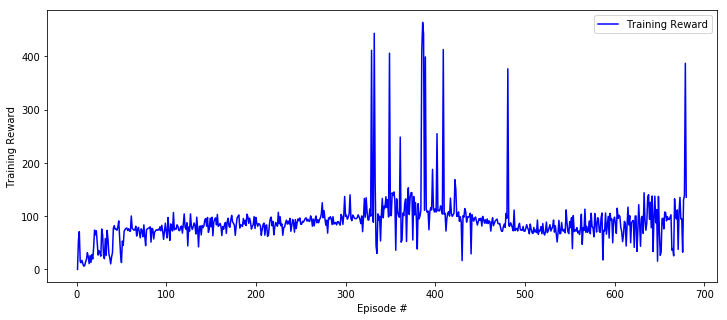

In [30]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = intermediate_folder_key + "/" + csv_file_name
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=['Training Reward'])

x_axis = 'Episode #'
y_axis = 'Training Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);
display(df)

### Clean Up

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [47]:
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

In [48]:
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

{'ResponseMetadata': {'RequestId': '28b0cc51-06c7-41ab-b97e-7e7eae8f67df',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '28b0cc51-06c7-41ab-b97e-7e7eae8f67df',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 09 Mar 2019 15:12:30 GMT'},
  'RetryAttempts': 0}}

### Evaluation

In [28]:
envriron_vars = {"MODEL_S3_BUCKET": s3_bucket,
                 "MODEL_S3_PREFIX": s3_prefix,
                 "ROS_AWS_REGION": aws_region,
                 "NUMBER_OF_TRIALS": str(20),
                 "MARKOV_PRESET_FILE": "%s.py" % RLCOACH_PRESET,
                 "WORLD_NAME": "hard_track",
                 }

simulation_application = {"application":simulation_app_arn,
                          "launchConfig": {"packageName": "deepracer_simulation",
                                           "launchFile": "evaluation.launch",
                                           "environmentVariables": envriron_vars}
                         }
                            
vpcConfig = {"subnets": default_subnets,
             "securityGroups": default_security_groups,
             "assignPublicIp": True}

response =  robomaker.create_simulation_job(iamRole=role,
                                        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                        maxJobDurationInSeconds=job_duration_in_seconds,
                                        failureBehavior="Continue",
                                        simulationApplications=[simulation_application],
                                        vpcConfig=vpcConfig,
                                        outputLocation={"s3Bucket":s3_bucket, "s3Prefix":s3_prefix_robomaker}
                                        )
print("Created the following job:")
print("Job ARN", response["arn"])

Created the following job:
Job ARN arn:aws:robomaker:us-east-1:571175237970:simulation-job/sim-277vfbv0t8jr


### Clean Up Simulation Application Resource

In [50]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': 'c579cdfc-427d-11e9-b157-5f6055231aef',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 09 Mar 2019 15:12:36 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c579cdfc-427d-11e9-b157-5f6055231aef',
   'x-amz-apigw-id': 'WR6rqEayIAMF36g=',
   'x-amzn-trace-id': 'Root=1-5c83d7e4-34f5287d44775df80cfd11ca;Sampled=0'},
  'RetryAttempts': 0}}